In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""   Gather results of the repeated simulations   -- Version 1.0
Last edit:  2023/06/12
Authors:    Leone, Riccardo (RL)
Notes:      - Evaluate the different combinations of b and w
            - Release notes:
                * Initial release
To do:      - 
Comments:   

Sources: 
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from petTOAD_setup import *


Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


In [2]:
EXPL_DIR = RES_DIR / "exploratory"
EXPL_FIG_DIR = EXPL_DIR / "Figures"
if not Path.exists(EXPL_FIG_DIR):
    Path.mkdir(EXPL_FIG_DIR)


In [3]:
def annotate_star(tbl):
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): '*'})
    return star

def save_plot_results(res_df, group):
    # Convert the result df into a pivot table so to plot heatmap
    table_fc = pd.pivot_table(res_df, values='fc_pearson', index='b', columns='w').astype(float)
    #table_fcd = pd.pivot_table(res_df, values='fcd_ks', index='b', columns='w').astype(float)
    table_phfcd = pd.pivot_table(res_df, values='phfcd_ks', index='b', columns='w').astype(float)
    # Create a composite score by summing up the single model fits
    table_sum = table_fc + table_phfcd

    # Create figure
    fig, axs = plt.subplots(1,3, figsize = (15,5))
    sns.heatmap(ax = axs[0],
                data = table_fc,
                annot = annotate_star(table_fc),
                fmt = '', 
                annot_kws={"size": 10})
    axs[0].set_title(f"FC {group}")

    # sns.heatmap(ax = axs[0,1],
    #             data = table_fcd,
    #             annot = annotate_star(table_fcd),
    #             fmt = '', 
    #             annot_kws={"size": 10})
    # axs[0,1].set_title(f"FCD {group}")

    sns.heatmap(ax = axs[1],
                data = table_phfcd, 
                annot = annotate_star(table_phfcd),
                fmt = '', 
                annot_kws={"size": 10})
    axs[1].set_title(f"1 - phFCD {group}")
    sns.heatmap(ax = axs[2],
                data = table_sum, 
                annot = annotate_star(table_sum),
                fmt = '', 
                annot_kws={"size": 10})
    axs[2].set_title(f"FC + (1 - phFCD) {group}")
    plt.savefig(EXPL_DIR / f"{group}_results_heatmap.png")


# Same list as the exploratory simulations
short_subjs = HC_WMH[:30]
short_subjs = np.append(short_subjs, HC_no_WMH[:30])
short_subjs = np.append(short_subjs, MCI_no_WMH[:30])
short_subjs = np.append(short_subjs, MCI_WMH[:30])


In [4]:
# Load wmh dictionary
wmh_dict = get_wmh_load_homogeneous(short_subjs)
# Create a overall df and populate it with single subject results
big_df = pd.DataFrame()
for subj in short_subjs[:-20]:
    res_df = pd.read_csv(EXPL_DIR / f"sub-{subj}_df_results_initial_exploration_wmh.csv", index_col=0)
    res_df['PTID'] = subj
    res_df['wmh_load'] = wmh_dict[subj]
    big_df = pd.concat([big_df, res_df], ignore_index=True)
# Let's work with 1-fcd and 1-phfcd so to have higher numbers = better fits
#big_df['fcd_ks'] = 1 - big_df['fcd_ks']
big_df['phfcd_ks'] = 1 - big_df['phfcd_ks']


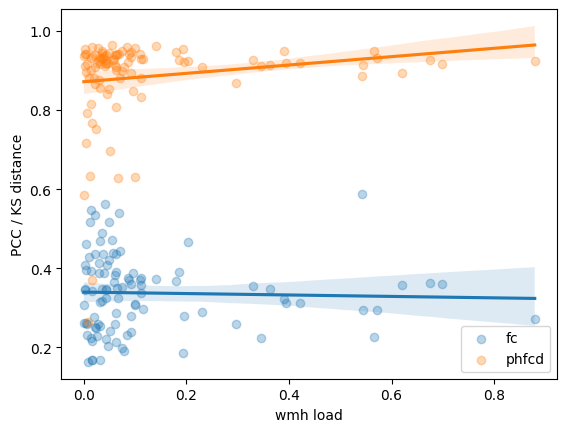

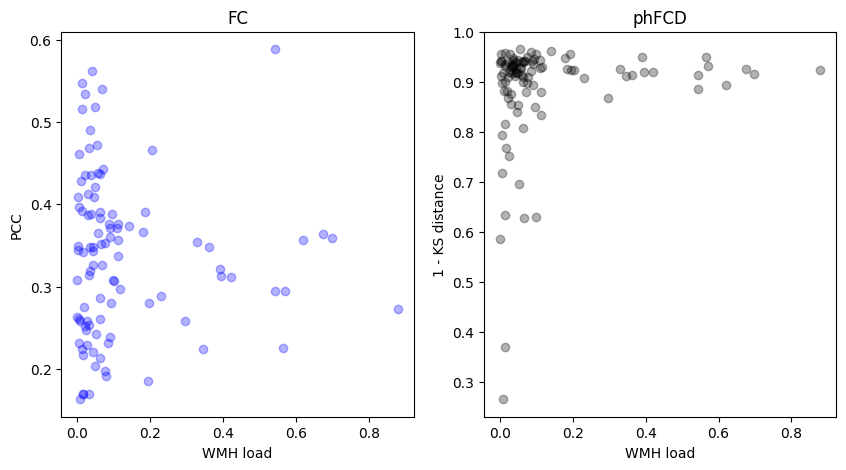

In [19]:
# Get the best model fits for fc, fcd, phfcd for each subject and create one single df
res_df_best = pd.DataFrame({'fc_pearson' : big_df.groupby(["PTID"])["fc_pearson"].max()}).reset_index()
#best_fcd = pd.DataFrame({'fcd_ks' : big_df.groupby(["PTID"])["fcd_ks"].max()}).reset_index()
best_phfcd = pd.DataFrame({'phfcd_ks' : big_df.groupby(["PTID"])["phfcd_ks"].max()}).reset_index()
#res_df_best = pd.concat([res_df_best, best_fcd])
res_df_best = pd.concat([res_df_best, best_phfcd])
res_df_best["wmh_load"] = [wmh_dict[subj] for subj in res_df_best['PTID']]
# Plot relationship between best model fits and wmh load 
# Here, all together, with regression
plt.figure()
ax1 = sns.regplot(res_df_best, y = 'fc_pearson', x = 'wmh_load', order = 1, scatter_kws={'alpha':0.3}, label = 'fc')
#ax2 = sns.regplot(res_df_best, y = 'fcd_ks', x = 'wmh_load', order = 2, scatter_kws={'alpha':0.3}, label = 'fcd')
ax3 = sns.regplot(res_df_best, y = 'phfcd_ks', x = 'wmh_load', order = 1, scatter_kws={'alpha':0.3}, label = 'phfcd')
ax3.set(ylabel = 'PCC / KS distance', xlabel = 'wmh load')
plt.legend()
plt.show()
plt.savefig(EXPL_FIG_DIR / "summary_best_values_regression.png")
plt.close()
# Here, separate, only with points
fig, axs = plt.subplots(ncols= 2, nrows = 1, figsize = (10, 5))
axs[0].plot(res_df_best['wmh_load'], res_df_best['fc_pearson'], 'bo', alpha = 0.3)
axs[0].set_ylabel('PCC')
axs[0].set_xlabel('WMH load')
axs[0].set_title('FC')
# axs[1].plot(res_df_best['wmh_load'], res_df_best['fcd_ks'], 'go', alpha = 0.3)
# axs[1].set_ylabel('1 - KS distance')
# axs[1].set_title('FCD')
axs[1].plot(res_df_best['wmh_load'], res_df_best['phfcd_ks'], 'ko', alpha = 0.3)
axs[1].set_ylabel('1 - KS distance')
axs[1].set_xlabel('WMH load')
axs[1].set_title('phFCD')
plt.savefig(EXPL_FIG_DIR / "summary_best_values_points.png")



In [6]:
# #%% This is based on wmh quartile in hc
# HC_no_WMH_1q = adnimerge[
#     (adnimerge["PTID"].isin(subjs))
#     & ((adnimerge["Group_bin_subj"] == "CN_no_WMH"))
# ]["PTID"].unique()

# HC_WMH_1q = adnimerge[
#     (adnimerge["PTID"].isin(subjs)) & ((adnimerge["Group_bin_subj"] == "CN_WMH"))
# ]["PTID"].unique()

# MCI_no_WMH_1q = adnimerge[
#     (adnimerge["PTID"].isin(subjs))
#     & ((adnimerge["Group_bin_subj"] == "MCI_no_WMH"))
# ]["PTID"].unique()

# MCI_WMH_1q = adnimerge[
#     (adnimerge["PTID"].isin(subjs))
#     & ((adnimerge["Group_bin_subj"] == "MCI_WMH"))
# ]["PTID"].unique()

# hc_no_wmh_df = big_df[big_df['PTID'].isin(HC_no_WMH_1q)]
# hc_no_wmh_grouped = hc_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
# save_plot_results(hc_no_wmh_grouped, "hc_no_wmh_1q")

# hc_wmh_df = big_df[big_df['PTID'].isin(HC_WMH_1q)]
# hc_wmh_grouped = hc_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
# save_plot_results(hc_no_wmh_grouped, "hc_wmh_1q")

# mci_no_wmh_df = big_df[big_df['PTID'].isin(MCI_no_WMH_1q)]
# mci_no_wmh_grouped = mci_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
# save_plot_results(mci_no_wmh_grouped, "mci_no_wmh_1q")

# mci_wmh_df = big_df[big_df['PTID'].isin(MCI_WMH_1q)]
# mci_wmh_grouped = mci_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
# save_plot_results(mci_wmh_grouped, "mci_wmh_1q")


In [7]:
adnimerge = pd.read_csv(RES_DIR / "petTOAD_dataframe.csv")
adnimerge["PTID"] = adnimerge["PTID"].str.replace("_", "")
big_df = big_df.rename(columns={'PTID': 'PTID'})
adnimerge = adnimerge.rename(columns={'Group_bin_Fazekas': 'Group_Fazekas_2.0'})
adnimerge["Group_Fazekas_1.0"] = np.where(
    adnimerge["Fazekas_periventricular"] + adnimerge["Fazekas_lobar"] < 2,
    adnimerge["Group_bin"] + "_no_WMH",
    adnimerge["Group_bin"] + "_WMH",
)

def perform_group_analyses(group):
    
    HC_WMH = adnimerge[adnimerge[group] == 'CN_WMH']['PTID']
    MCI_WMH = adnimerge[adnimerge[group] == 'MCI_WMH']['PTID']

    #HC_no_WMH = adnimerge[adnimerge[group] == 'CN_no_WMH']['PTID']
    # hc_no_wmh_df = big_df[big_df['PTID'].isin(HC_no_WMH)]
    # hc_no_wmh_grouped = hc_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(hc_no_wmh_grouped, "hc_no_wmh_Fazekas_1.0")

    hc_wmh_df = big_df[big_df['PTID'].isin(HC_WMH)]
    hc_wmh_grouped = hc_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    save_plot_results(hc_wmh_grouped, f"hc_wmh_{group}")

    #MCI_no_WMH = adnimerge[adnimerge[group] == 'MCI_no_WMH']['PTID']
    # mci_no_wmh_df = big_df[big_df['PTID'].isin(MCI_no_WMH)]
    # mci_no_wmh_grouped = mci_no_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    # save_plot_results(mci_no_wmh_grouped, "mci_no_wmh_Fazekas_1.0")

    mci_wmh_df = big_df[big_df['PTID'].isin(MCI_WMH)]
    mci_wmh_grouped = mci_wmh_df.drop(columns=["PTID"]).groupby(["b", "w"]).mean()
    save_plot_results(mci_wmh_grouped, f"mci_wmh_{group}")


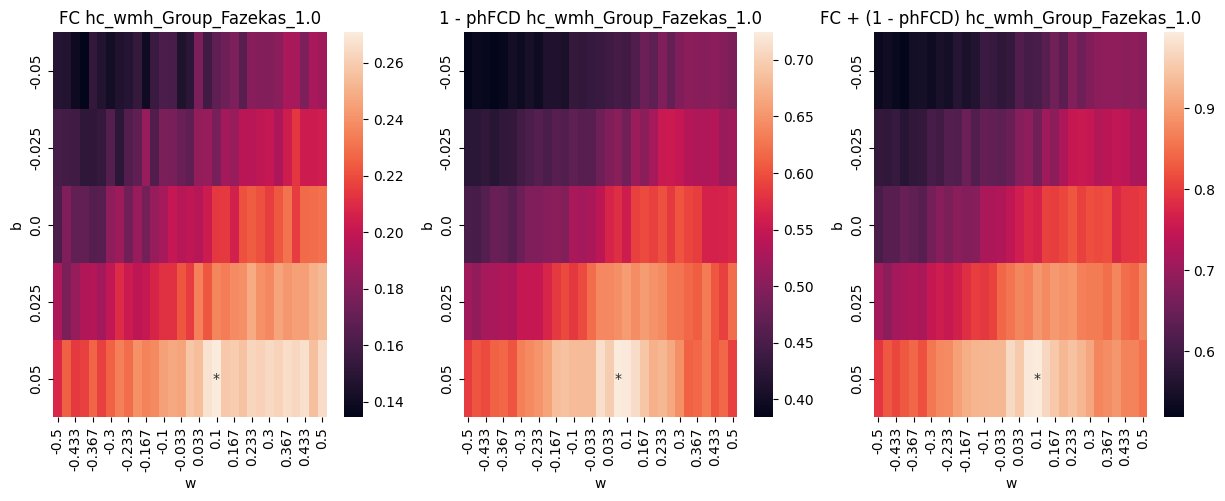

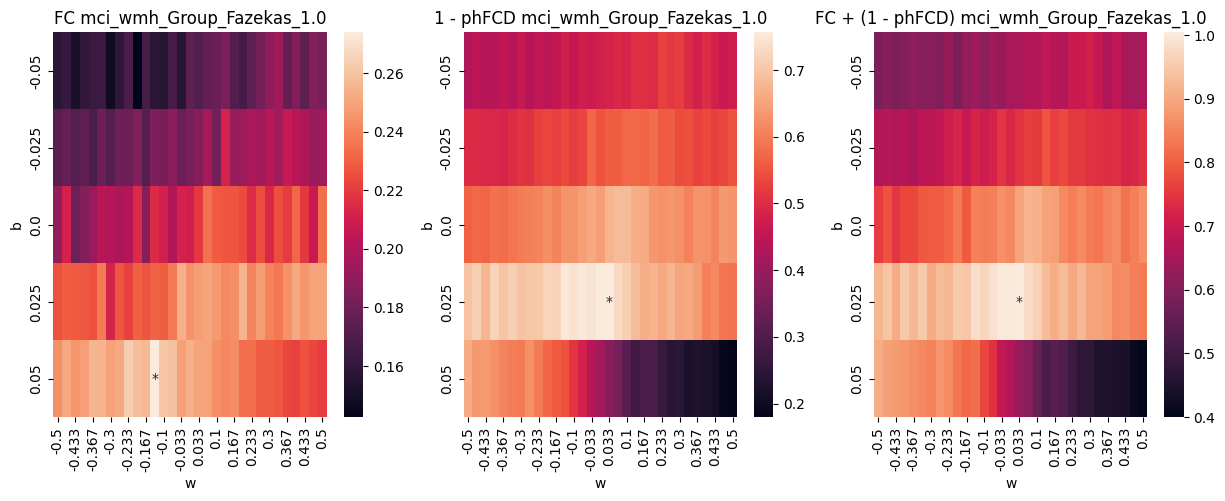

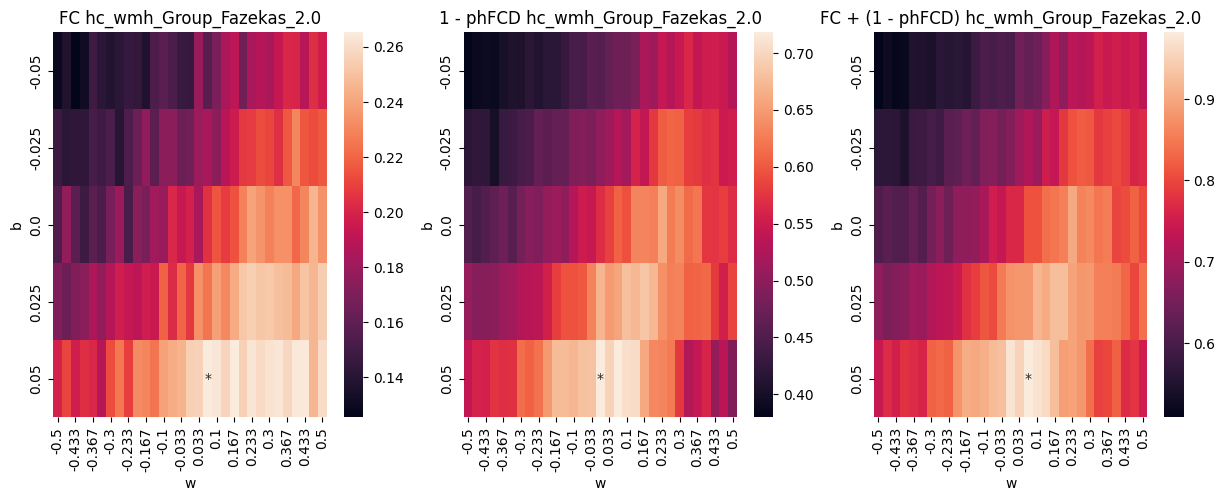

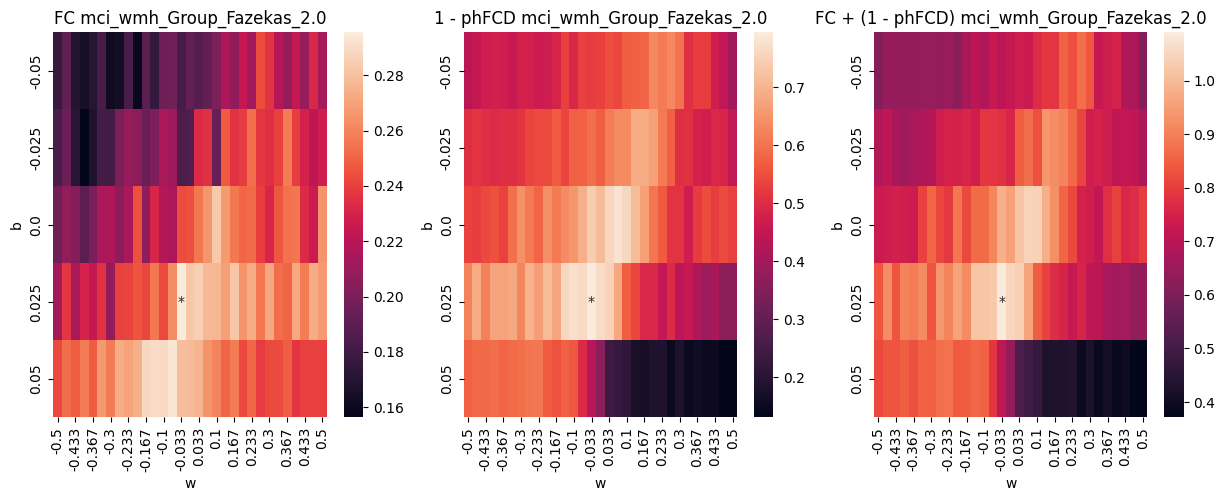

In [8]:
perform_group_analyses('Group_Fazekas_1.0')
perform_group_analyses('Group_Fazekas_2.0')


In [33]:
# df_boxplot = big_df[(big_df['b'] == 0.1) | (big_df['b'] == 0.1)]
# df_boxplot = pd.merge(df_boxplot, adnimerge[['PTID','Group_Fazekas_2.0', 'Group_Fazekas_1.0']], on = 'PTID')
# df_boxplot_long = pd.melt(df_boxplot, id_vars=['PTID', 'w', 'fc_pearson', 'phfcd_ks'], value_vars=['Group_Fazekas_2.0', 'Group_Fazekas_1.0'], var_name='group', value_name='values')
# df_boxplot_long['group_values'] = df_boxplot_long['group'] + '_' + df_boxplot_long['values']
# #only show subjects with WMH
# dummy_cat = pd.CategoricalDtype(['CN_WMH', 'MCI_WMH'])
# order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]
# n=2
# fig, axs = plt.subplots(n, 2, figsize = (10, 10))
# for i, w in enumerate(df_boxplot_long['w'].unique()[:n]):
#     w_df = df_boxplot_long[df_boxplot_long['w'] == w]
#     sns.boxplot(ax = axs[i][0],
#                 data = w_df, 
#                 x = 'values', 
#                 y = 'fc_pearson', 
#                 hue = 'group', 
#                 order=order)
#     sns.boxplot(ax = axs[i][1],
#                 data = w_df, 
#                 x = 'values', 
#                 y = 'phfcd_ks', 
#                 hue = 'group', 
#                 order=order)

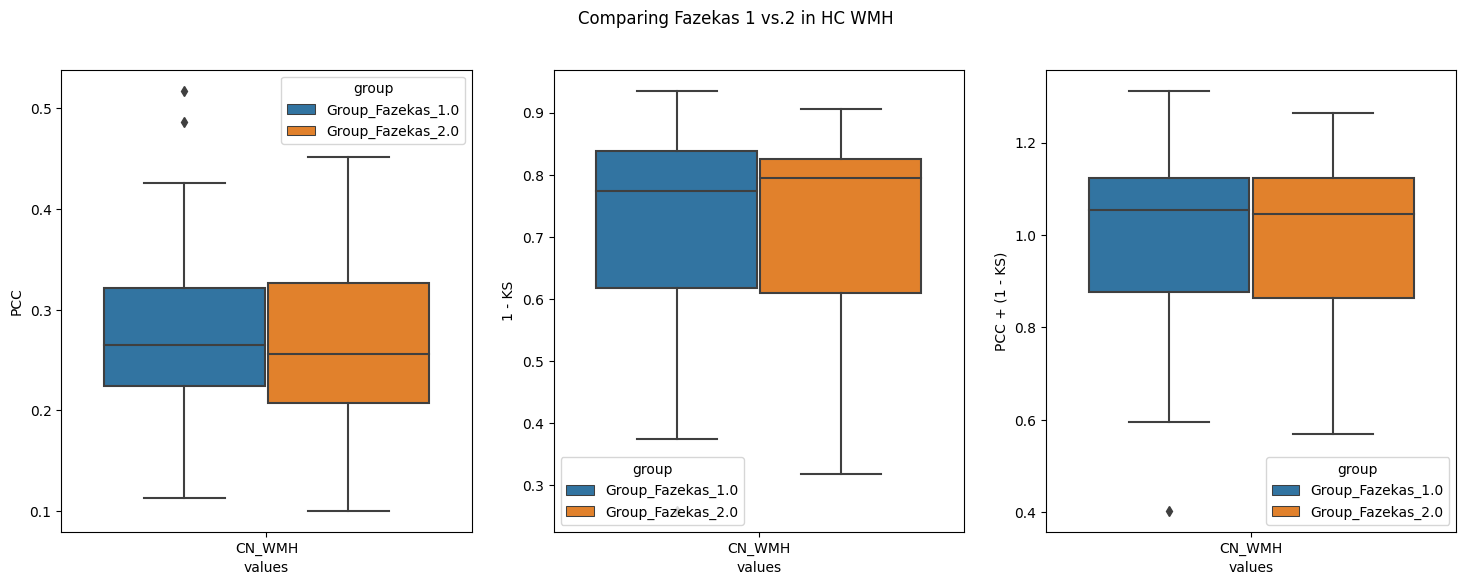

In [32]:
# Create a smaller dataset only with b = 0.05 and b=0.025 since those seem the best
df_boxplot = big_df[(big_df['b'] == 0.05) | (big_df['b'] == 0.025)]
# Merge this database with just the column of interest
df_boxplot = pd.merge(df_boxplot, adnimerge[['PTID','Group_Fazekas_2.0', 'Group_Fazekas_1.0']], on = 'PTID')
# Pivot to long
df_boxplot_long = pd.melt(df_boxplot, id_vars=['PTID', 'w', 'b', 'fc_pearson', 'phfcd_ks'], value_vars=['Group_Fazekas_2.0', 'Group_Fazekas_1.0'], var_name='group', value_name='values')
df_boxplot_long['group_values'] = df_boxplot_long['group'] + '_' + df_boxplot_long['values']
df_boxplot_long['summed_fc_phfcd'] = df_boxplot_long['fc_pearson'] + df_boxplot_long['phfcd_ks']

#Helpful to only show the categories we want to show in the boxplot and not those without WMH
dummy_cat = pd.CategoricalDtype(['CN_WMH'])
order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]

# By looking at the graphs for HC WMH, the best w and b for both types of groupings criteria
# happen to be b = 0.1 and w = -0.03 (compensatory activity?)
compare_df_hc_2 = df_boxplot_long[(df_boxplot_long['w'] == 0.067) & (df_boxplot_long['b'] == 0.05)]
compare_df_hc_2 = compare_df_hc_2[compare_df_hc_2['group'] == 'Group_Fazekas_2.0']
compare_df_hc_1 = df_boxplot_long[(df_boxplot_long['w'] == 0.1) & (df_boxplot_long['b'] == 0.05)]
compare_df_hc_1 = compare_df_hc_1[compare_df_hc_1['group'] == 'Group_Fazekas_1.0']
joined_compare_df_hc = pd.concat([compare_df_hc_1, compare_df_hc_2])

fig, axs = plt.subplots(1,3, figsize = (18, 6))
sns.boxplot(ax = axs[0],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'fc_pearson', 
            hue = 'group', 
            order=order)
axs[0].set_ylabel('PCC')
sns.boxplot(ax = axs[1],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'phfcd_ks', 
            hue = 'group', 
            order=order)
axs[1].set_ylabel('1 - KS')
sns.boxplot(ax = axs[2],
            data = joined_compare_df_hc, 
            x = 'values', 
            y = 'summed_fc_phfcd', 
            hue = 'group', 
            order=order)
axs[2].set_ylabel('PCC + (1 - KS)')
fig.suptitle('Comparing Fazekas 1 vs.2 in HC WMH')
plt.savefig(EXPL_FIG_DIR / "compare_best_b_w_among_groupings_hc_wmh.png")

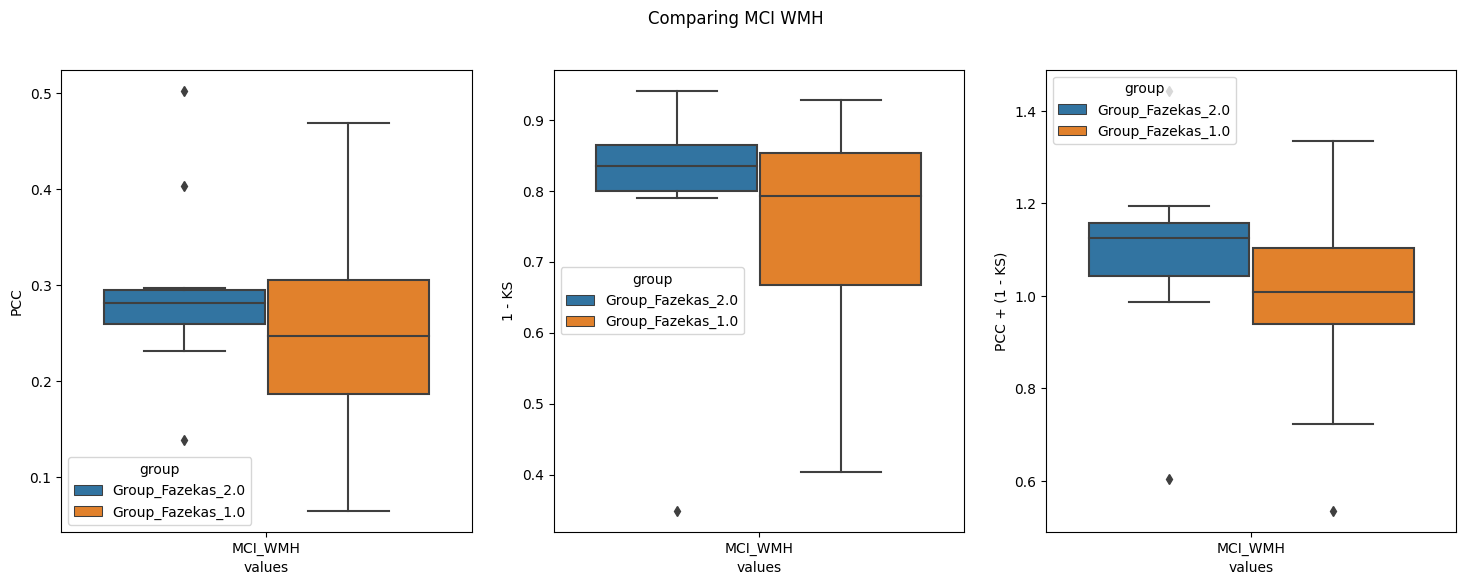

In [35]:

# By looking at the graphs for MCI WMH, the best w and b for both types of groupings criteria
# happen to be b = 0 and, respectively w = 0.04 for Fazekas <=2 and w = 0.07 for Fazekas <2
compare_df_mci_2 = df_boxplot_long[(df_boxplot_long['w'] == -0.033) & (df_boxplot_long['b'] == 0.025)]
compare_df_mci_2 = compare_df_mci_2[compare_df_mci_2['group'] == 'Group_Fazekas_2.0']
compare_df_mci_1 = df_boxplot_long[(df_boxplot_long['w'] == 0.033) & (df_boxplot_long['b'] == 0.025)]
compare_df_mci_1 = compare_df_mci_1[compare_df_mci_1['group'] == 'Group_Fazekas_1.0']
joined_compare_df = pd.concat([compare_df_mci_2, compare_df_mci_1])
dummy_cat = pd.CategoricalDtype(['MCI_WMH'])
order = [cat for cat in dummy_cat.categories if df_boxplot_long['values'].str.contains(cat).any()]

fig, axs = plt.subplots(1,3, figsize = (18, 6))
sns.boxplot(ax = axs[0],
            data = joined_compare_df, 
            x = 'values', 
            y = 'fc_pearson', 
            hue = 'group', 
            order=order)
axs[0].set_ylabel('PCC')
sns.boxplot(ax = axs[1],
            data = joined_compare_df, 
            x = 'values', 
            y = 'phfcd_ks', 
            hue = 'group', 
            order=order)
axs[1].set_ylabel('1 - KS')
sns.boxplot(ax = axs[2],
            data = joined_compare_df, 
            x = 'values', 
            y = 'summed_fc_phfcd', 
            hue = 'group', 
            order=order)
axs[2].set_ylabel('PCC + (1 - KS)')
fig.suptitle('Comparing MCI WMH')
plt.savefig(EXPL_FIG_DIR / "compare_best_b_w_among_groupings_mci_wmh.png")

In [40]:
wmh_HC_WMH = np.array([wmh_dict[subj] for subj in short_subjs if subj in HC_WMH])
wmh_MCI_WMH = np.array([wmh_dict[subj] for subj in short_subjs if subj in MCI_WMH])

as_HC_WMH = -0.02 + wmh_HC_WMH * 0.067 + 0.05 
as_MCI_WMH = -0.02 + wmh_HC_WMH * -0.033 + 0.025

Text(0.5, 1.0, 'Distribution of best wmh-weighted bif. parms. in HC & MCI with WMH')

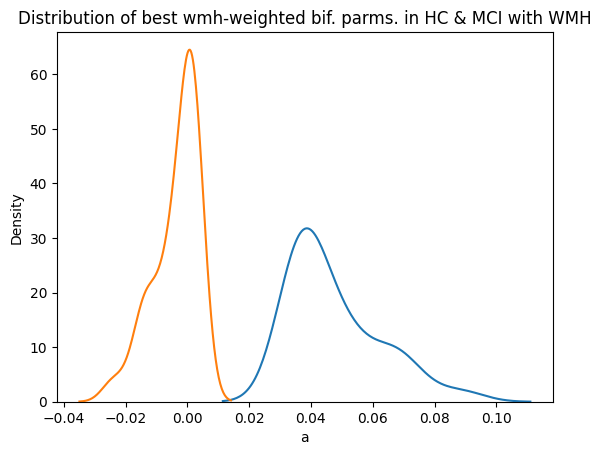

In [49]:
sns.kdeplot(as_HC_WMH, label = 'HC with WMH')
sns.kdeplot(as_MCI_WMH, label = 'MCI with WMH')
plt.xlabel('a')
plt.title('Distribution of best wmh-weighted bif. parms. in HC & MCI with WMH')